## Tutorial 5: MERFISH mouse hypothalamic preoptic region data

## 1 Import modules

In [1]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
import Castl

## 2 Load data and genelist

In [2]:
counts_matrix = pd.read_csv('../data/MERFISH/MERFISH_Animal18_Bregma0.11_countdata.csv', index_col=0)
coordinates = pd.read_csv('../data/MERFISH/MERFISH_Animal18_Bregma0.11_info.csv', index_col=0)

common_cells = counts_matrix.index.intersection(coordinates.index)
counts_matrix = counts_matrix.loc[common_cells]
coordinates = coordinates.loc[common_cells]

adata = AnnData(X=counts_matrix, obs=coordinates)
adata.obsm['spatial'] = coordinates[['x', 'y']].values
adata.var_names_make_unique()
adata.obs["x_pixel"] = pd.Series(adata.obsm['spatial'][:, 1], index=adata.obs.index)
adata.obs["y_pixel"] = pd.Series(adata.obsm['spatial'][:, 0], index=adata.obs.index)
sc.pp.log1p(adata)
adata

D:\Apps\Anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4975 × 160
    obs: 'x', 'y', 'Cell_class', 'x_pixel', 'y_pixel'
    uns: 'log1p'
    obsm: 'spatial'

In [3]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/MERFISH/MERFISH_{method}_results_processed.csv'
    var_name = f'{method}_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

In [4]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/MERFISH/MERFISH_stabl/MERFISH_{method}_stabl_processed.csv'
    var_name = f'{method}_combined_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

## 3 Run Castl

### 3.1 Rank aggregation

gene  score  rank  pred
34      Pak3  976.0     1     1
15       Mbp  973.0     2     1
93   Slc17a6  926.0     3     1
14      Prlr  908.0     4     1
154     Sgk1  891.0     5     1

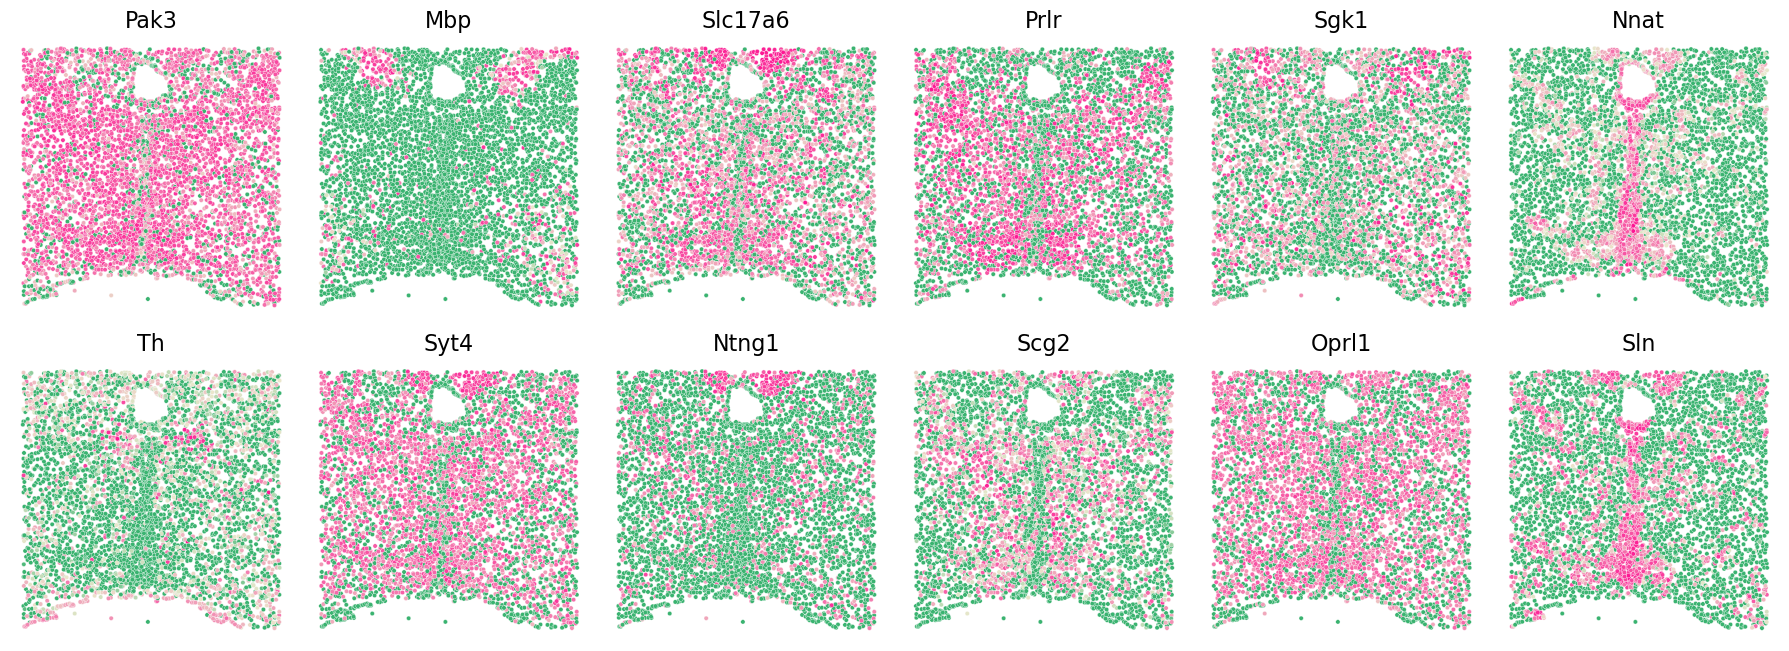

In [5]:
rank_agg_genelist = Castl.rank_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    rank_col='adjusted_p_value',
    ascending=True,
    top_percent=0.1
)

Castl.plot_gene(
    adata=adata,
    gene_df=rank_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='score',
    ascending=False,
    top_n=12,
    spotsize=10,
    figsize=(18, 6.8)
)

rank_agg_genelist.head()

### 3.2 P-value aggregation

gene  combined_p_value  adjusted_p_value  rank  pred
0     Ucn3               0.0               0.0     1     1
102   Bdnf               0.0               0.0     2     1
101  Cspg5               0.0               0.0     3     1
100   Ebf3               0.0               0.0     4     1
99    Nos1               0.0               0.0     5     1

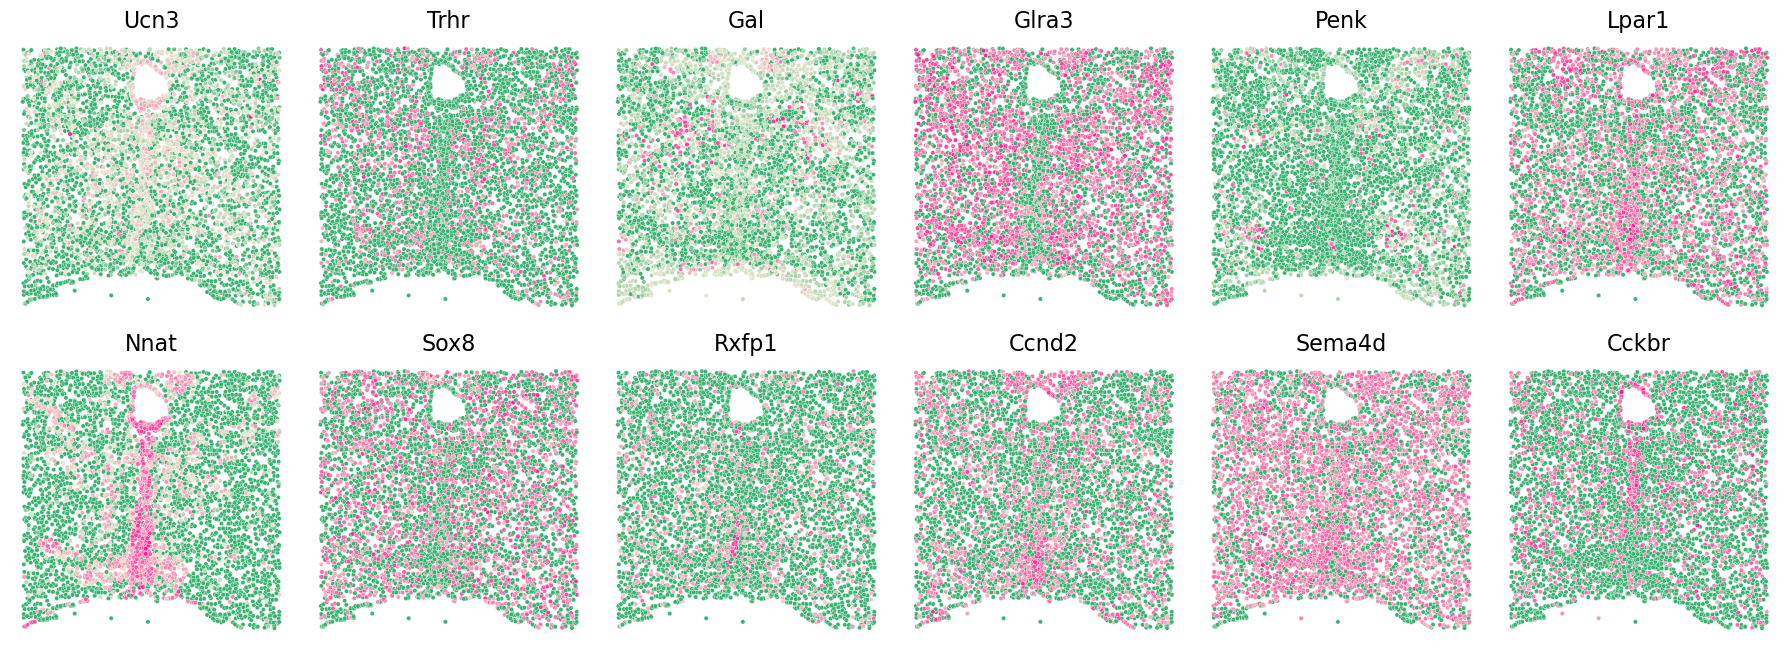

In [6]:
pval_agg_genelist = Castl.pval_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    pvalue_col='adjusted_p_value',
    correction='fdr_by'
)

Castl.plot_gene(
    adata=adata,
    gene_df=pval_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='adjusted_p_value',
    ascending=True,
    top_n=12,
    spotsize=10,
    figsize=(18, 6.8)
)

pval_agg_genelist.head()

### 3.1 Stabl aggregation

Optimal threshold: 0.152
Total SVGs selected: 135
ArtGene count in selection: 0
Non-ArtGene count in selection: 135


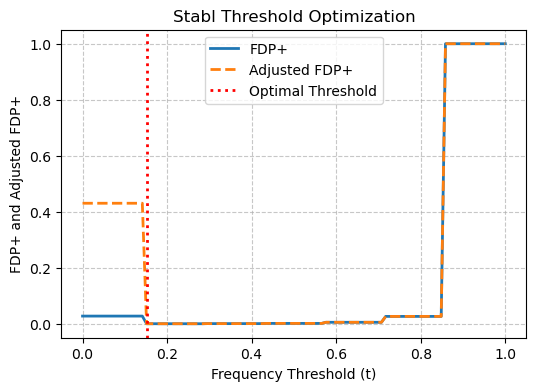

gene  frequency  rank  pred
92   Gabrg1   0.857143     1     1
189    Irs4   0.857143     2     1
107    Mlc1   0.857143     3     1
101  Cxcl14   0.857143     4     1
97     Pak3   0.857143     5     1

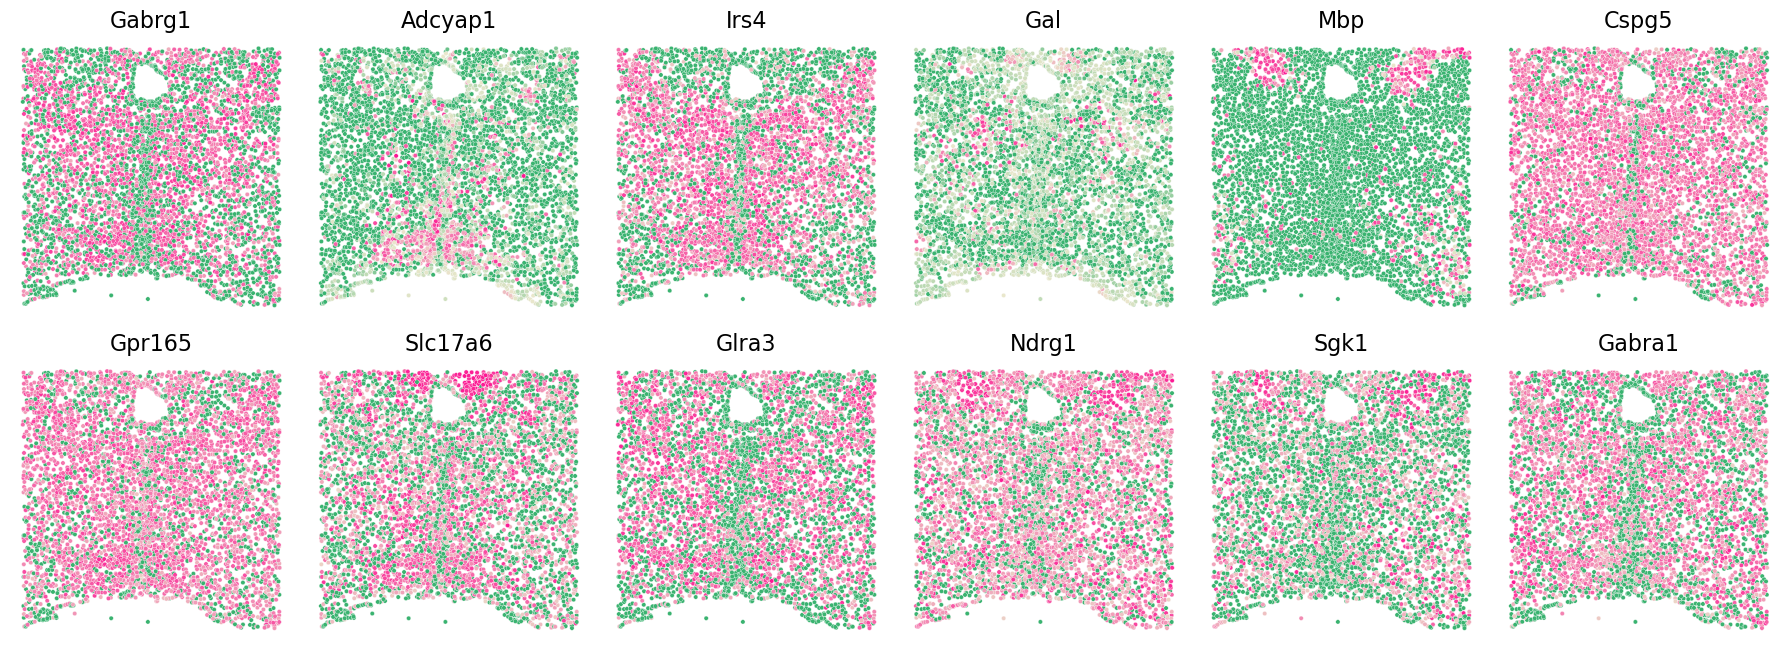

In [7]:
stabl_agg_genelist = Castl.stabl_agg(
    gene_list=[spatialde_combined_genelist, spark_combined_genelist, sparkx_combined_genelist, 
               somde_combined_genelist, spagcn_combined_genelist, spanve_combined_genelist, heartsvg_combined_genelist],
    gene_col = 'gene',
    pred_col = 'pred',
    penalty_factor=0.1,
    plot=True
)

Castl.plot_gene(
    adata=adata,
    gene_df=stabl_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='frequency',
    ascending=False,
    top_n=12,
    spotsize=10,
    figsize=(18, 6.8)
)

stabl_agg_genelist.head()